In [1]:
import numpy as np
import datetime

import matplotlib.pyplot as plt

from scipy.optimize import minimize

import astropy.units as u
from astropy.wcs import WCS
from astropy.time import Time
from astropy.table import Table, join, vstack
from astropy.io import fits
from astropy.visualization.wcsaxes.frame import EllipticalFrame

from photutils import CircularAperture

from skycam_utils.astrometry import update_altaz
from skycam_utils.photometry import load_skycam_catalog, load_mask
from skycam_utils.pipeline import process_stellacam_image
from skycam_utils.fit_wcs import wcs_zea, wcs_refine_zea
from skycam_utils.fisheye_map import Fisheye, distortion_mapper, distortion_mapper_looper

In [2]:
skycat = load_skycam_catalog()

In [3]:
hdul = fits.open("image_0003000.fits.gz")
im = hdul[0].data
hdr = hdul[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  640                                                  
NAXIS2  =                  480                                                  
EXTEND  =                    T                                                  
GAIN    =                  106                                                  
FRAME   = '256 Frames'                                                          
UT      = 'MON OCT 16 07:59:33 2017'                                            
LST     = '02:16:09.777'                                                        
AZ      =         179.28606672                                                  
EL      =          53.16977134                                                  
SCOPEX  =                  3

In [4]:
dt = datetime.datetime.strptime(hdr['UT'], "%a %b %d %H:%M:%S %Y")
tobs = Time(dt, scale='utc')
tobs

<Time object: scale='utc' format='datetime' value=2017-10-16 07:59:33>

In [5]:
skycat = update_altaz(skycat, time=tobs)

In [6]:
wcs_initial = WCS("../2019/wcs.fits")
wcs_refined = WCS("../2020/wcs_refined.fits")

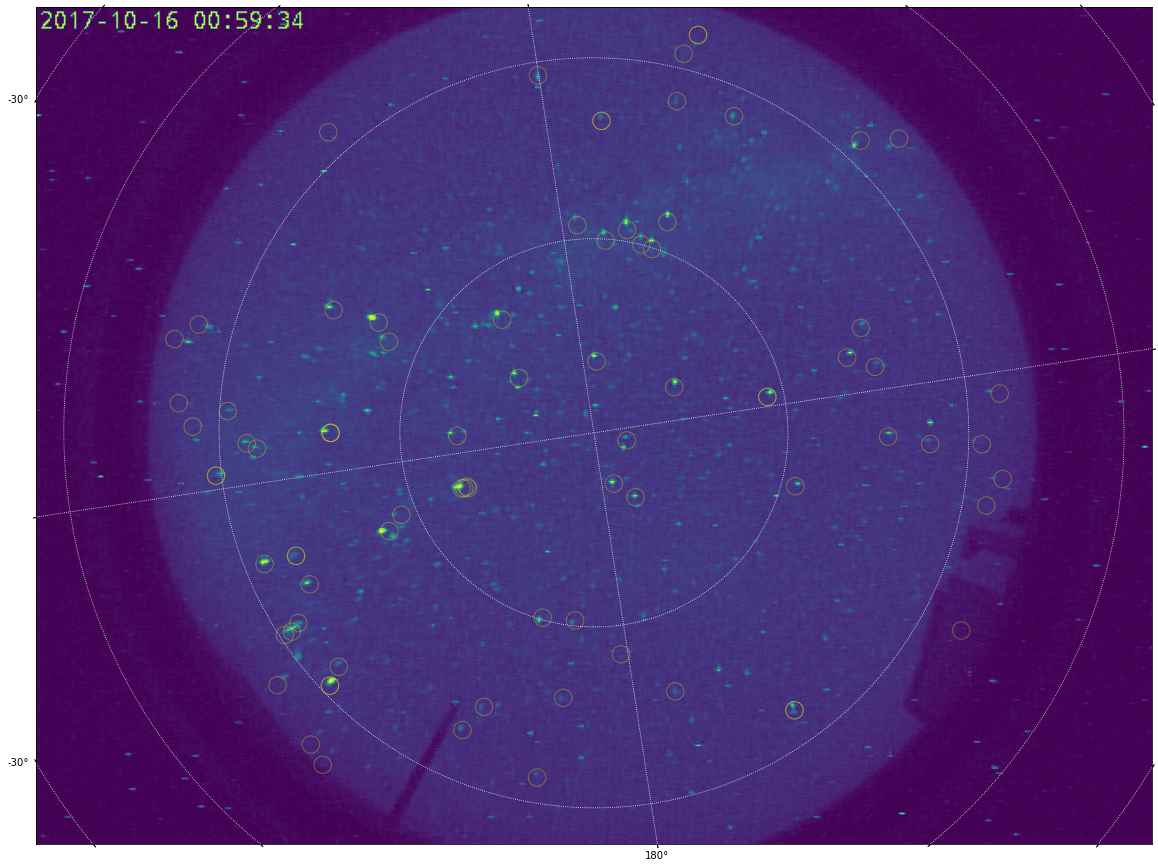

In [7]:
plt.figure(figsize=[20,20])
skycat = skycat[skycat['Alt'] > 20.0]
skycat = skycat[skycat['Magnitude'] < 4]
pred_x, pred_y = wcs_initial.all_world2pix(skycat['Az'], skycat['Alt'], 0)
pred_aps = CircularAperture((pred_x, pred_y), r=5.)
ax = plt.subplot(projection=wcs_initial)
ax.imshow(im, origin='lower')
ax.coords[0].set_format_unit(u.deg)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.grid(color='white', ls='dotted')
pred_aps.plot(color='yellow', lw=1., alpha=0.3)
plt.show()

In [8]:
mask = load_mask(year=2017)

In [11]:
bkg_image, diff_image, segm, sky_mag, catalog = process_stellacam_image("image_0003000.fits.gz", wcs=wcs_initial, mask=mask, write=True, zp=0)